# 1. Исследовательский анализ данных

In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image

labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
                                                   directory = '/datasets/faces/final_files/',
                                                   x_col='file_name',
                                                   y_col='real_age',
                                                   target_size=(224, 224),
                                                   batch_size=32,
                                                   class_mode='raw',
                                                   seed=42)


Found 7591 validated image filenames.


In [ ]:
features, target = next(train_gen_flow)
features.shape

(32, 224, 224, 3)

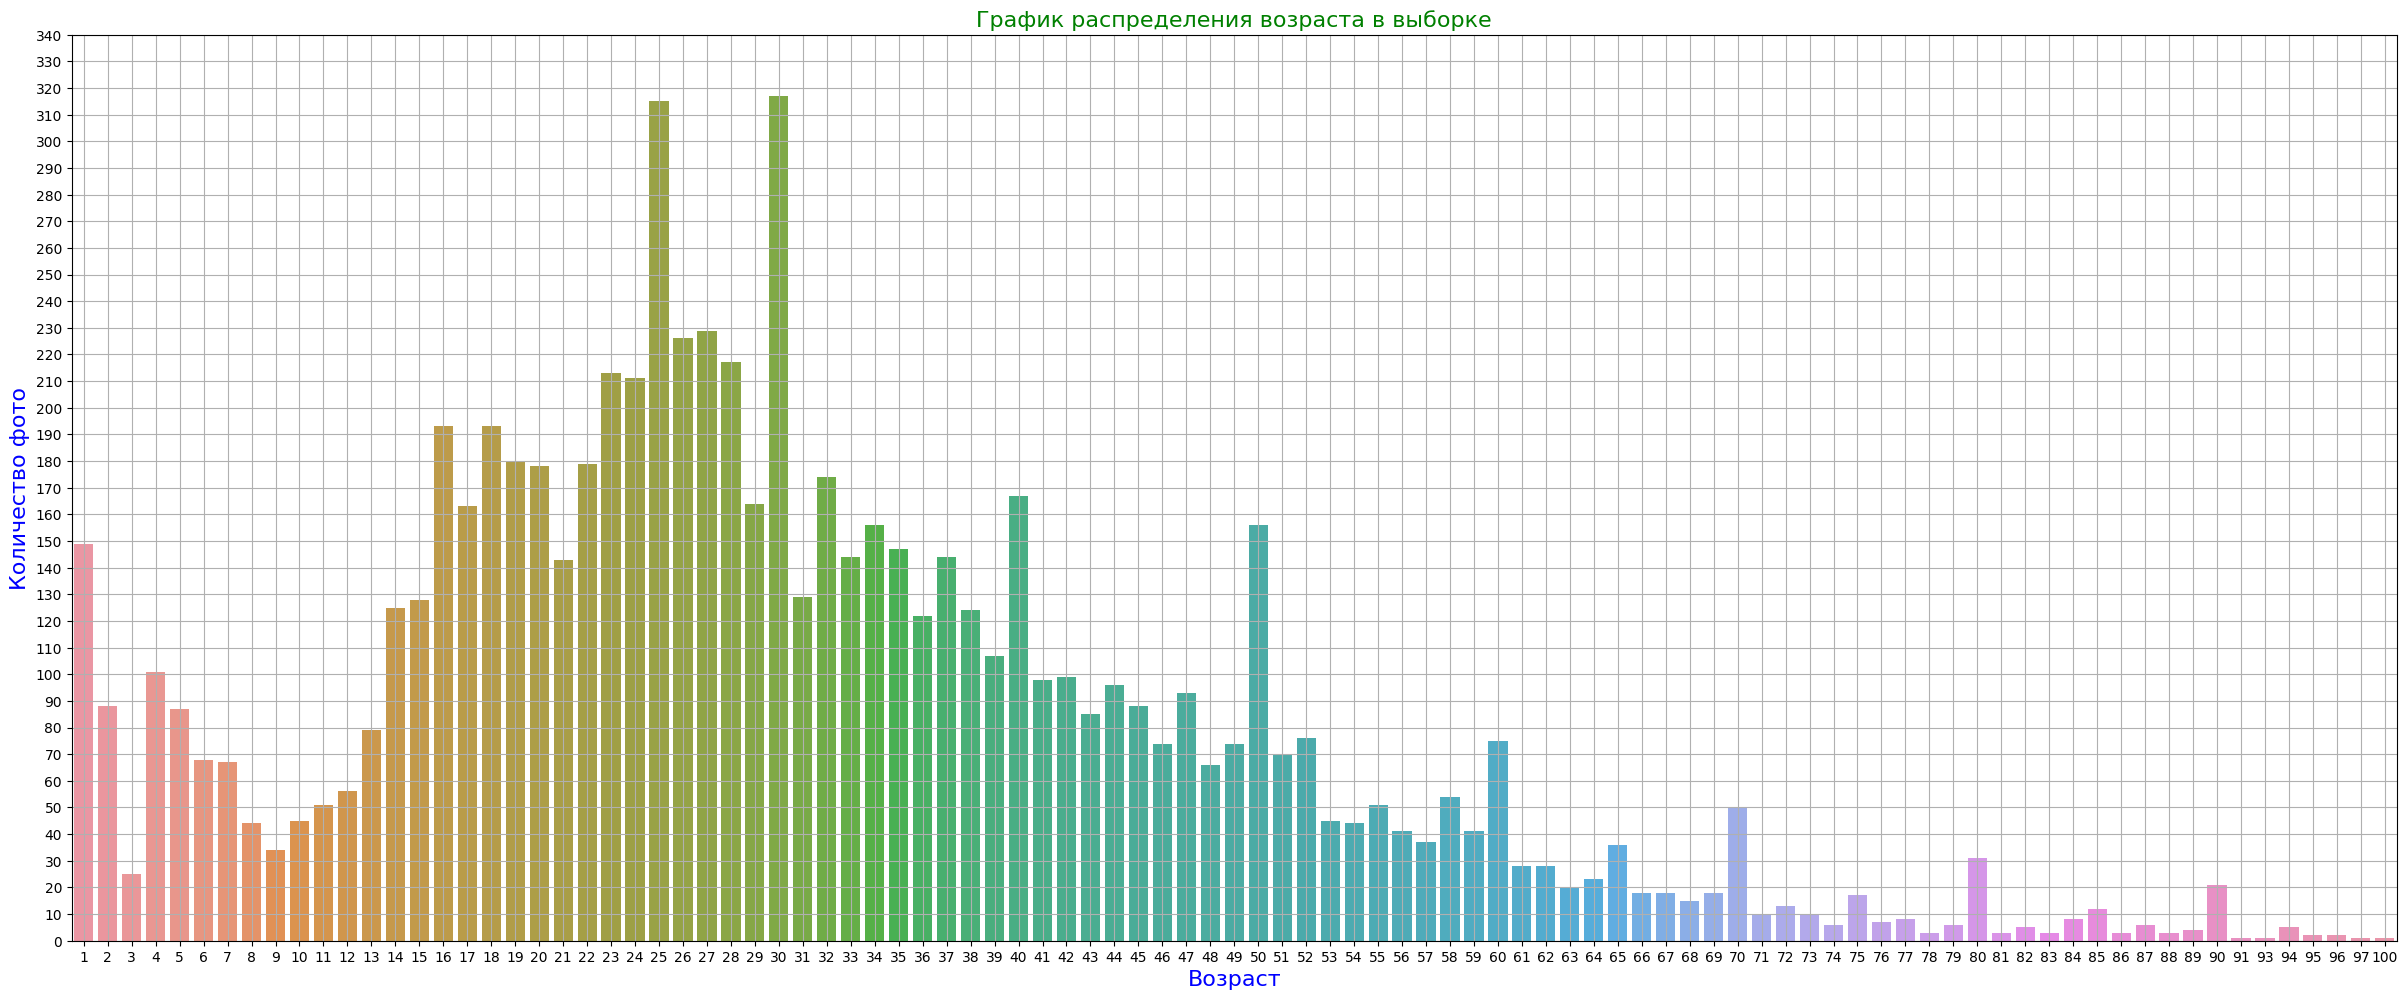

In [ ]:
age = labels.groupby('real_age').count().reset_index(drop=False)

plt.subplots(figsize=(30,12), dpi=100)
sns.barplot(y='file_name',
            x='real_age',
            data=age);
plt.grid(True)
plt.xlabel('Возраст', fontsize=16, color='blue')
plt.ylabel('Количество фото', fontsize=16, color='blue')
plt.title('График распределения возраста в выборке', fontsize=16, color='green')
plt.yticks(range(0, 350, 10))
plt.show()

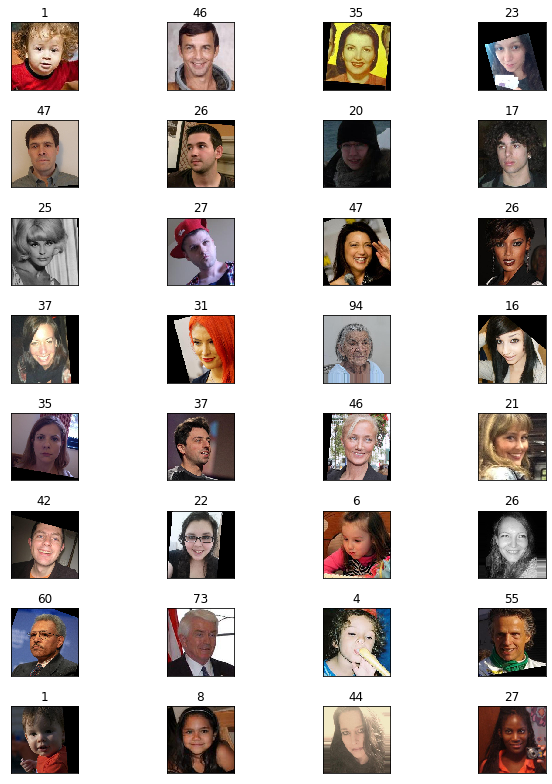

In [ ]:
fig = plt.figure(figsize=(11,11))
for i in range(32):
    fig.add_subplot(8, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(target[i])
    plt.tight_layout()

### Выводы:

- На граффике мы видим что преобладающим возрастным диапазоном является 25-30 лет, затем идут диапазоны 15-24 и 32-40, пожилых людей и детей младше 15 лет намного меньше. Из этого можно предположить, что модель обученная на этих данных будет лучше предсказывать возрас у 20-40 летних людей, а у пожилых людей (старше 60) и детей (8-11 лет) качество предсказание будет самым низким.


- Так же можно выявить следующую закономерность: на круглых датах (40, 50, 60, 70, 80, 90) и на 1 мы видим пики, которые можно объяснить выбросами.


- Размер датасета вполне пододит для обучения, но его можно увеличить, если сделать отражение фотографий повертикали. Тогда размер датасета увеличится вдвое

# 2. Обучение модели

```python

import numpy as np
import pandas as pd
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50





def load_train(path):
    labels = pd.read_csv(path + 'labels.csv') 
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       validation_split=0.25)
    train_gen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
                                                       directory = path + 'final_files/',
                                                       x_col='file_name',
                                                       y_col='real_age',
                                                       target_size=(224, 224),
                                                       batch_size=32,
                                                       class_mode='raw',
                                                       subset='training',
                                                       seed=42)
    
    return train_gen_flow
    

def load_test(path): 
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255,
                                      validation_split=0.25)
    test_gen_flow = test_datagen.flow_from_dataframe(dataframe=labels,
                                                       directory = path + 'final_files/',
                                                       x_col='file_name',
                                                       y_col='real_age',
                                                       target_size=(224, 224),
                                                       batch_size=32,
                                                       class_mode='raw',
                                                       subset='validation',
                                                       seed=42)
    
    return test_gen_flow


def create_model(input_shape):

    
    backbone = ResNet50(input_shape = input_shape, weights = 'imagenet', include_top = False)
    
    model = Sequential()

    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1))
    model.compile(optimizer=Adam(lr=0.00005), loss='mean_squared_error',
                  metrics=['mae'])
    
    return model



def train_model(model, train_data, test_data, epochs=6,
               steps_per_epoch=None, validation_steps=1, batch_size=None):


    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    
    model.fit(train_data,
              validation_data=test_data,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    
    return model

```

```

Train for 178 steps, validate for 1 steps
Epoch 1/6
2020-08-06 19:45:11.955107: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-08-06 19:45:12.272672: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 37s - loss: 300.0433 - mae: 12.6019 - val_loss: 1038.9604 - val_mae: 25.7082
Epoch 2/6
2020-08-06 19:46:10.651172: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
178/178 - 28s - loss: 62.7695 - mae: 6.0022 - val_loss: 1084.8754 - val_mae: 26.3308
Epoch 3/6
2020-08-06 19:46:39.484767: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
178/178 - 29s - loss: 30.5101 - mae: 4.2588 - val_loss: 815.7921 - val_mae: 20.5440
Epoch 4/6
2020-08-06 19:47:08.127413: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
178/178 - 29s - loss: 20.3388 - mae: 3.4745 - val_loss: 213.5153 - val_mae: 11.0960
Epoch 5/6
2020-08-06 19:47:36.985154: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
178/178 - 29s - loss: 16.2211 - mae: 3.1047 - val_loss: 135.3370 - val_mae: 8.4206
Epoch 6/6
2020-08-06 19:48:05.346454: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
178/178 - 28s - loss: 15.2807 - mae: 3.0130 - val_loss: 88.7706 - val_mae: 7.0042
2020-08-06 19:48:05.621963: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 74.8700 - mae: 6.5231
Test MAE: 6.5231
```

# 3. Анализ обученной модели

Итоговое МАЕ модели составляет 6.5, что достаточно неплохо. Но, я думаю модель можно улучшить попробовав поменять learning rate и увеличив количество эпох, так как время обучения позволяет.